**Instructions**  

Run the notebook to load the pretrained BERT model and pre-created SHAP explanations  

Alternatively, load a newly trained model or re-create the SHAP explanations from scratch  

For full commented and referenced code on the model aspect, see the FELTD BERT model notebook, only the SHAP code is commented here

This code was adapted from: https://shap.readthedocs.io/en/latest/example_notebooks/text_examples/sentiment_analysis/Emotion%20classification%20multiclass%20example.html where marked "(see ref above)" otherwise it is original

In [1]:
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import shap
import scipy as sp
from datasets import load_dataset
import torch

In [2]:
from torch import nn, optim

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

In [5]:
df = pd.read_csv('text_emotion_cleaned.csv', dtype={'tweet_without_stopwords': str})
df['content']=df['tweet_without_stopwords'].astype('str')
df['label'] = pd.factorize(df['sentiment'])[0].astype(np.uint16)
df_train = df.iloc[:32000]
df_valid = df.iloc[32000:36000]
df_test = df.iloc[36000:40000]

labels = list(df['sentiment'].unique())

In [6]:
class SentimentClassifier(nn.Module):
    '''With Softmax for eval mode'''
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
        input_ids=input_ids, 
        attention_mask=attention_mask, return_dict=False) 

        output = self.drop(pooled_output)
        output = self.out(output)
        return output

In [7]:
# https://github.com/huggingface/transformers/issues/2094
model = SentimentClassifier(len(labels))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
# load pretrained model
model.load_state_dict(torch.load('BERT-weights.bin')) 
model = model.to(device)

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

**SHAP explanations**

In [10]:
#define processing function for SHAP - adapted from (see ref above)

def f(x):
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=50,truncation=True) for v in x]).to(device)
    attention_mask = (tv!=0).type(torch.int64).to(device)
    outputs = model(tv,attention_mask=attention_mask).detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores)
    return val

In [11]:
#create SHAP explainer (see ref above)
explainer = shap.Explainer(f,tokenizer,output_names=labels)

In [13]:
#load pre-created SHAP explanations
import pickle
with open('my_shap_values.pkl', "rb") as f:
    shap_values = pickle.load(f)

In [14]:
# #ALTERNATIVELY, re-create the SHAP explanations from scratch
# #NB takes over an hour on a fast machine
# shap_values = explainer(df_train['content'][:]) #1:18:11

empty


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


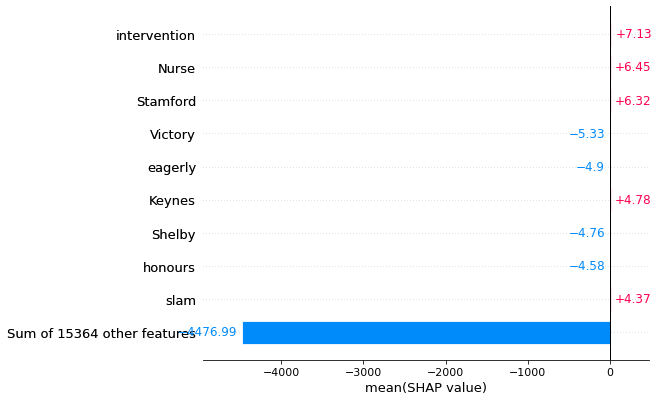

None
sadness


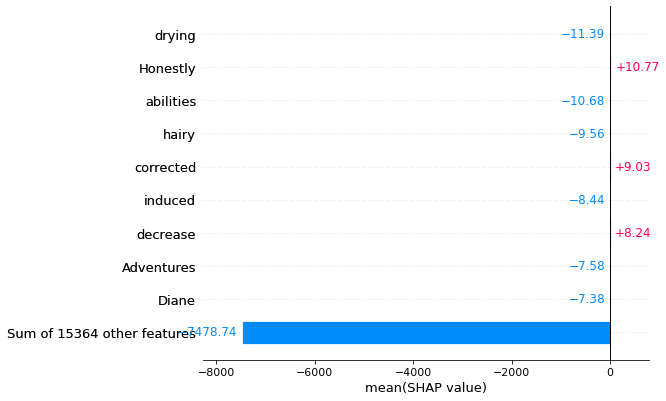

None
enthusiasm


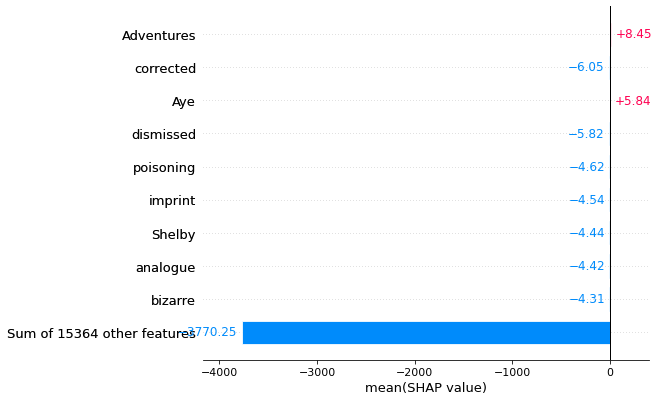

None
neutral


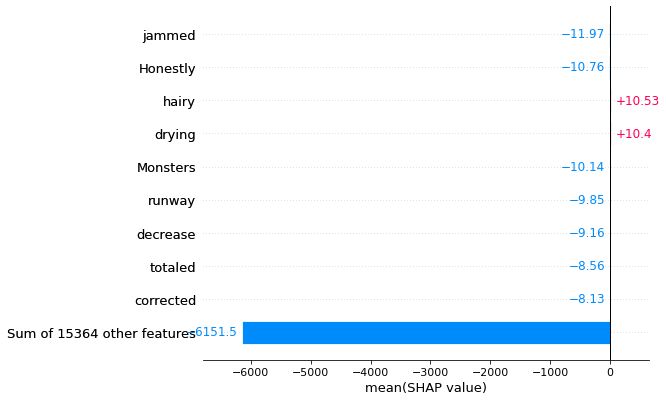

None
worry


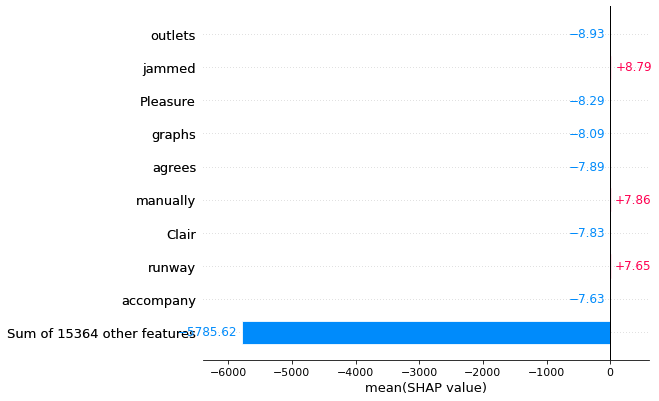

None
surprise


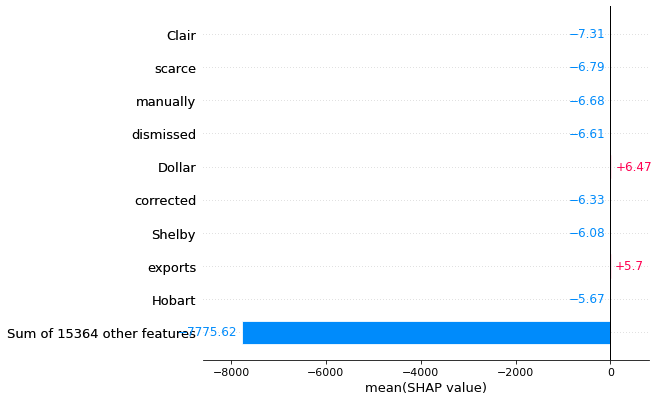

None
love


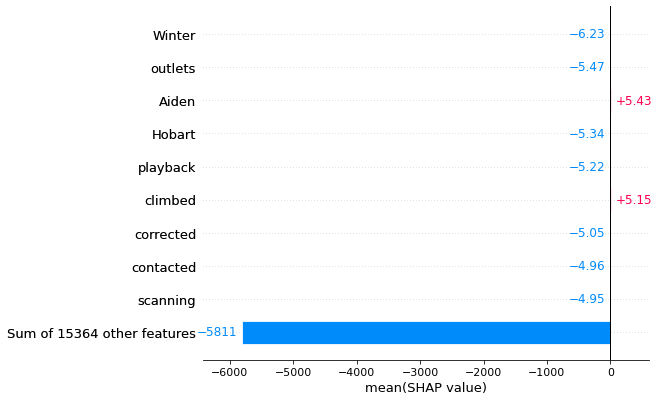

None
fun


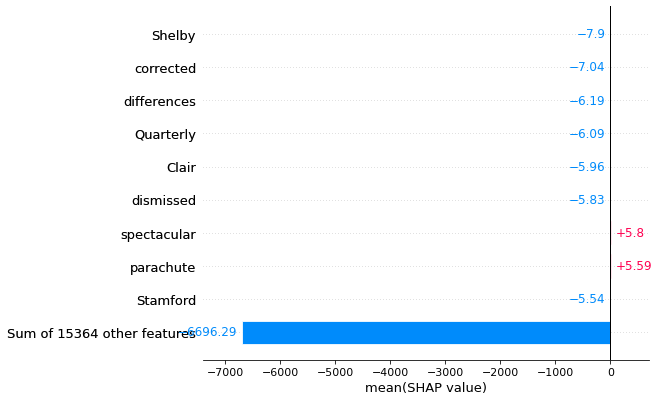

None
hate


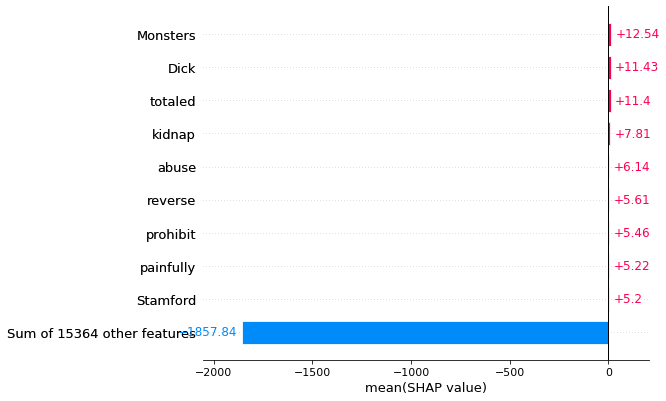

None
happiness


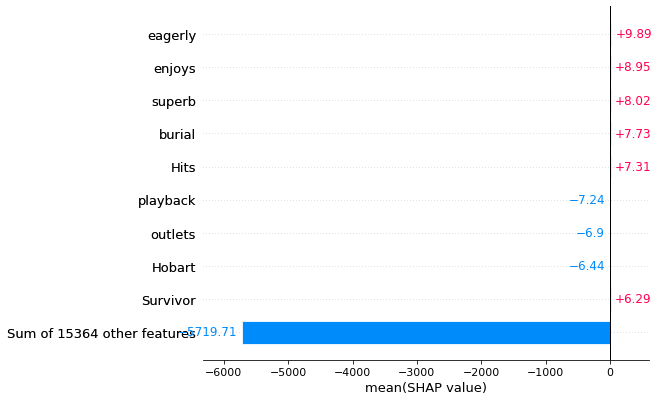

None
boredom


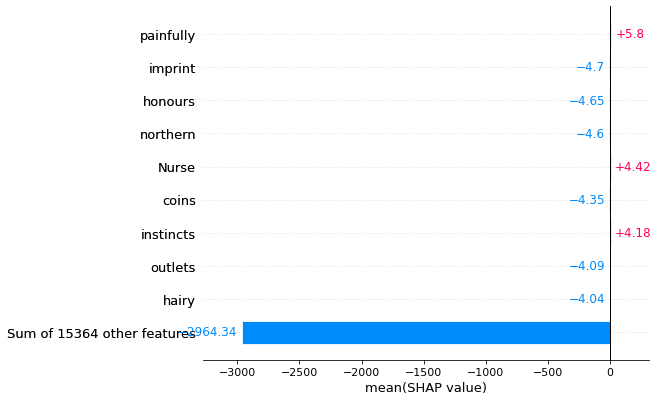

None
relief


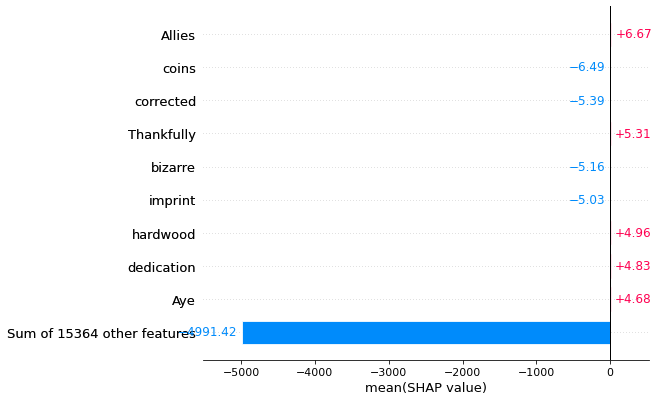

None
anger


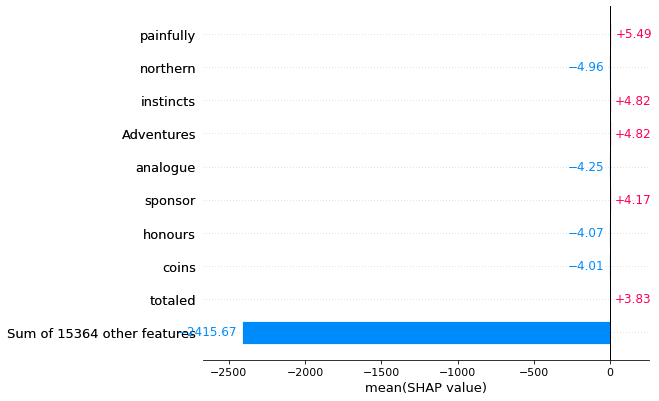

None


In [15]:
#display explanations for each class
for label in range(len(labels)):
    print(labels[label])
    print(shap.plots.bar(shap_values[:,:,label].mean(0))) #(see ref above) - this line only in this cell

Single item explanations

In [16]:
idx = 8 #specify single tweet index 

In [17]:
#change datatypes to make a single tweet work with SHAP
ser = pd.Series(df_train['content'][idx])
ser
single_shap_values = explainer(ser)

empty


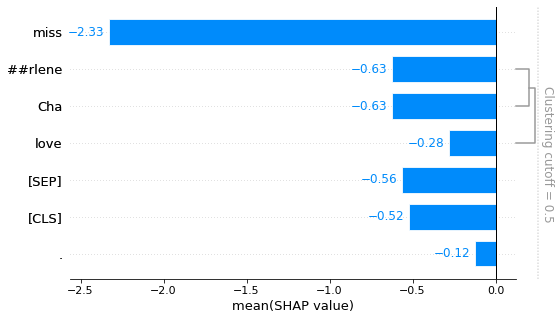

None
sadness


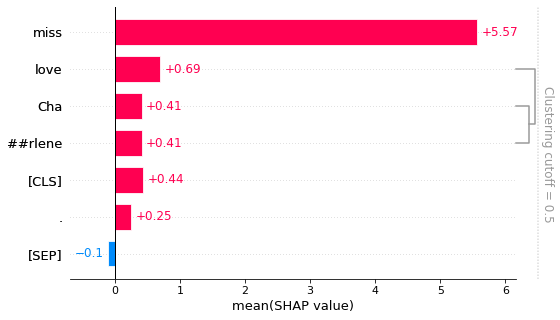

None
enthusiasm


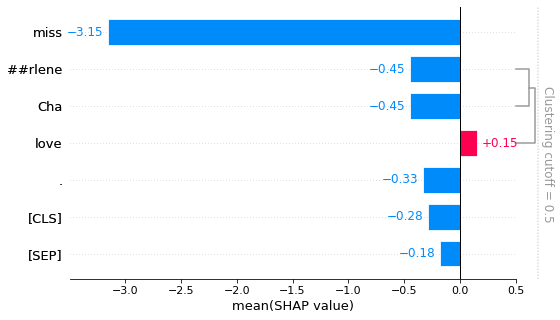

None
neutral


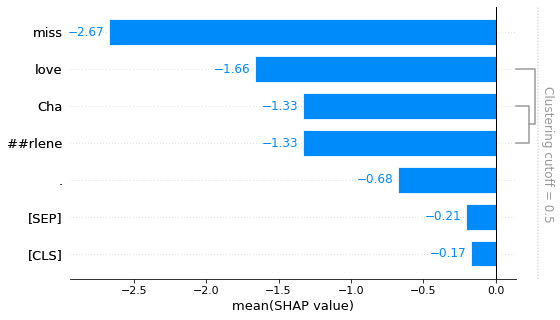

None
worry


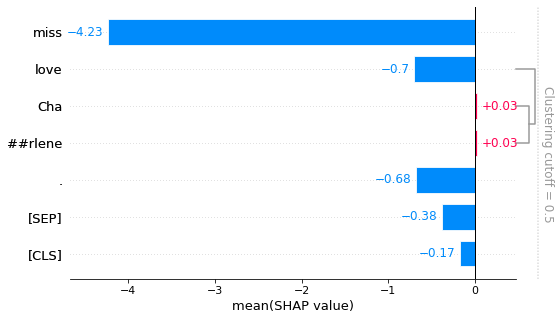

None
surprise


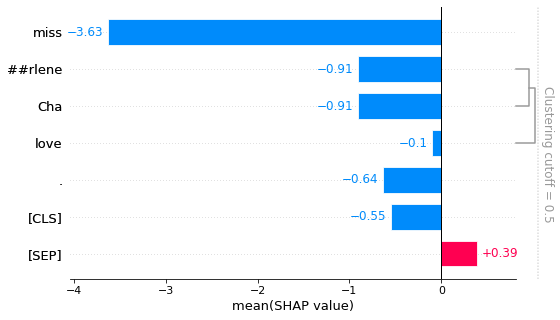

None
love


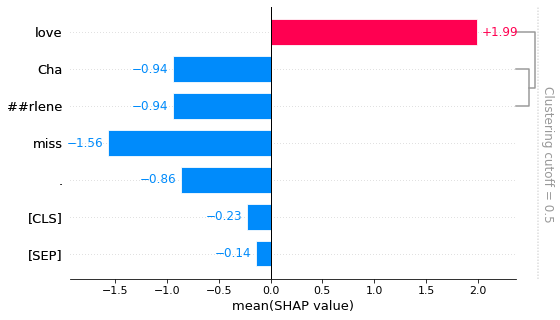

None
fun


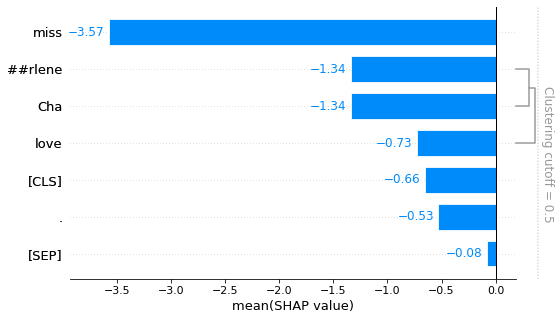

None
hate


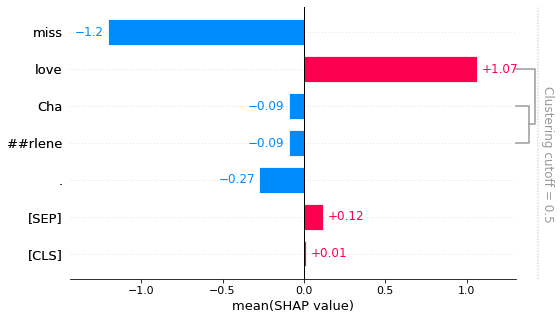

None
happiness


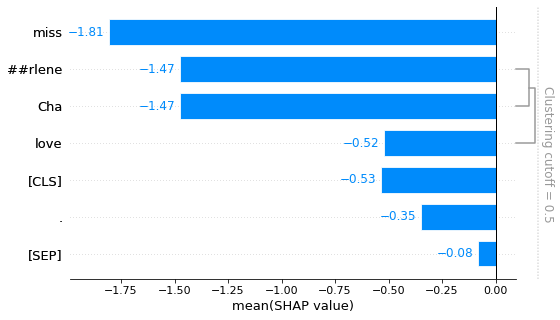

None
boredom


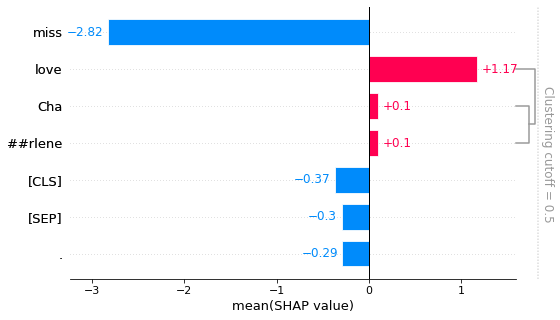

None
relief


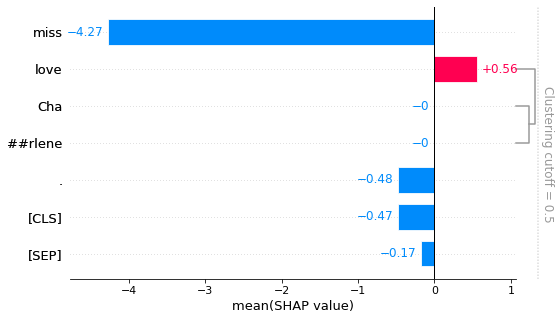

None
anger


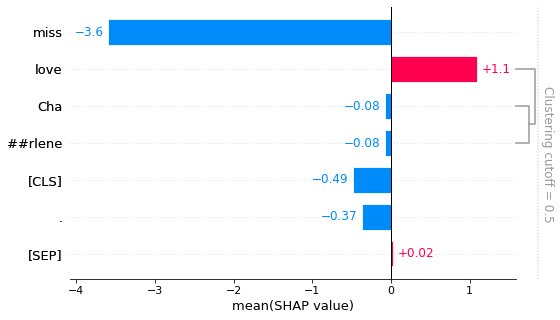

None


In [18]:
#show
for label in range(len(labels)):
    print(labels[label])
    print(shap.plots.bar(single_shap_values[:,:,label].mean(0))) #(see ref above) - this line only in this cell